*NOTES:* 
* Throughout the lab, set the random state or numpy seed to 0 to replicate my results exactly.
* for the histograms, use 20 bins

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Part 1 - Fisher's linear discriminant (2 classes)

For equations, refer to Bishop's book, Section 4.1.4

## Exercise 1 - Generate data

* Use scikit-learn to generate 2 blobs of data in 2D. Generate a dataset consisting of 600 points, divided into 2 classes.
* Make a figure with the scatter plot of the data
* Plot a histogram of the data projected on each of the 2 dimensions

In [39]:
from sklearn.datasets import make_blobs
import pandas as pd
import seaborn as sns

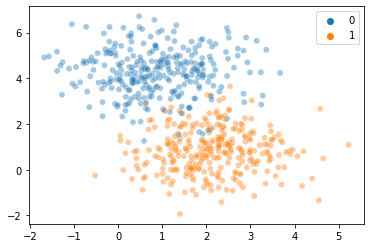

In [40]:
#Aqui, estou criando um conjunto de dados com 2 classes 0 e 1
#E consequentemente com duas gaussianas, uma para cada classe
#Defini que os dados só terão duas colunas
X, y = make_blobs(n_samples=600, n_features=2, centers=2, random_state=0)

fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, alpha=0.4, ax=ax)
plt.show()
plt.close()

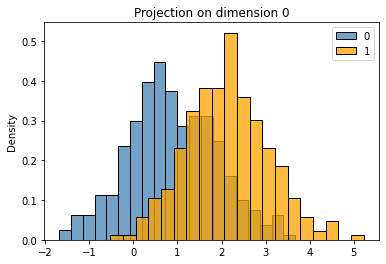

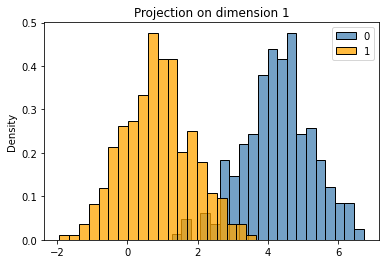

In [41]:
colors = ['steelblue', 'orange', 'green']
# Diante disso, faz-se necessário plotar uma projeção da distribuição 
# dos dados sobre cada dimensão

def plot_projection(X,y, dimension):
    fig, ax = plt.subplots()
    #Definindo a quantidade de classes do conjunto
    labels = np.unique(y)
    #Neste "for" será feito um histograma para cada classe do conjunto
    for col, l in enumerate(labels):
        idx = y==l
        sns.histplot(X[idx], stat='density', 
                    ax=ax, label=l, bins=20,
                    color=colors[col])
    ax.set_title(f'Projection on dimension {dimension}')
    ax.legend()
    # plt.show()
    # plt.close("all")

#Plot com os dados da dimensão 0
plot_projection(X[:,0], y, 0)

#Plot com os dados da dimensão 1
plot_projection(X[:,1], y, 1)


## Exercise 2 - Implement Fisher's linear discriminant

* Use numpy to calculate $\vec{w}$ (suggestion, use the equations from the Bishop book)
* Project the points into the calculated vector, and plot the data, a line on the direction of w
* Show the accuracy of the prediction on the following projections
    * component 0 of the data
    * component 1 of the data
    * the calculated vector $\vec{w}$
    * **Use this classifier:** the single gaussian bayes classifier from the previous labs. 
    * Optional challenge: using the sklearn API
* Print the angle between the learned vector $\vec{w}$, and the vector defined by the means of the classes $\vec{\mu_1} - \vec{\mu_0}$

In [42]:
#Armazenando as variáveis de classe 0
c0 = y==0
#Armazenando as variáveis que não são de classe 0
c1 = ~c0

#Calculando a média dos dados que possui duas colunas
m0 = X[c0].mean(axis=0).reshape(-1,1)
m1 = X[c1].mean(axis=0).reshape(-1,1)


#Calculando a covariância de cada da transporta de cada blob
S_w = np.cov(X[c0].T)+np.cov(X[c1].T) #Esse é um método mais rápido

S_w_inv = np.linalg.inv(S_w)

w = S_w_inv @ (m0-m1) 
# Se implementado usando o Bishop eq 4.28

#Projetando os dados em w
#Normalizando o vetor w 
n2 = np.linalg.norm(w.reshape(-1)) ** 2

#calculando a reta em que os dados serão projetados
proj = (X @ w/ n2)*w.T


(-2.0283593821589108,
 7.4900856554028845,
 -2.369547437953211,
 7.148897599608585)

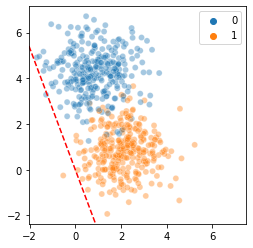

In [43]:
fig, ax = plt.subplots()
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, alpha=0.4, ax=ax)
#Encontrando o vetor normlizado w
u = w/np.linalg.norm(w)
wa = u.reshape(-1)

#plotando uma linha perpendicular a esse vetor
#Nessa posição as gaussianas possuem a menor variação.
ax.axline((-wa[0], -wa[1]), (wa[0], wa[1]), color='r', ls='--', label='solution')
# ax.axline(xy1=(0,2),xy2=(wa[1],-wa[0]))
ax.axis('square')


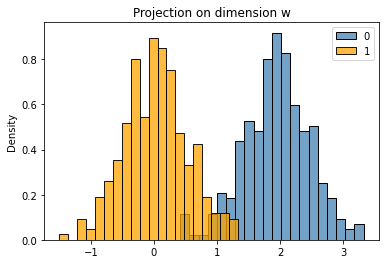

In [44]:
#Projeção em W
#NÂO ENTENDI O X @ W
proj1d =  (X @ w/n2).flatten()
plot_projection(proj1d, y,"w")


In [45]:
# your code here

In [46]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.mixture import GaussianMixture
from sklearn.utils import check_X_y
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal

#Fazendo um modelo para fazer as predições
#O modelo será feito sobre os dados projetados
#Para isso usaremos um modelo de gaussianas
class SingleGaussianClassifier(BaseEstimator, ClassifierMixin):
    #Armazenando variáveis do objeto.
    def __init__(self):
        self.labels = []
        self.priors_ = {}
        self.gaussians_ = {}
        self.gms_ = {} 

    def _fit_priors(self, y):
        for label in self.labels_:
            #Calculando os priors de cada classe
            self.priors_[label] = y[y == label].shape[0]/y.shape[0]
    
    def _fit_gaussians(self, X, y):
        #Calculando a likelihood de cada gaussiana
        for label in self.labels_:
            X_label = X[y == label]
            #Calculando a Gaussiana de cada classe
            gm = GaussianMixture(n_components=1).fit(X_label)
            self.gms_[label] = gm
            #Usando scipy, armazenei a "fórmula" da gaussiana
            self.gaussians_[label] = multivariate_normal(mean=gm.means_[0],                                           cov=gm.covariances_[0]).pdf

    def fit(self, X, y):
        #Algoritmo checa se não há inf ou nan
        #Se tiver, ele remove em X e y
        X,y = check_X_y(X,y)
        #Obtendo cada classe existente em y
        self.labels_ = np.unique(y)
        self._fit_priors(y)
        self._fit_gaussians(X,y)
        return self
    
    def predict_proba(self, X):
        posteriors=[]
        #Nessa função vamos calcular os posteriors de cada ponto
        for label in self.labels_:
            likelihood = self.gaussians_[label](X)
            priors = self.priors_[label]
            posteriors += [likelihood*priors]
        return np.array(posteriors).T
    
    def predict(self,X):
        vector_predict = np.array([])
        for i in np.argmax(self.predict_proba(X), axis=1):
            vector_predict= np.append(vector_predict,i)
        return vector_predict

        
g = SingleGaussianClassifier()
g.fit(X@w/n2,y)
# g.predict_proba(X@w/n2)
g.predict(X@w/n2)
accuracy = accuracy_score(g.predict(X@w/n2), y)
print(f"Accuracy:{accuracy}")

Accuracy:0.965


In [47]:
#Como sabemos, o objetivo principal do discriminant de fisher é:
#Definir uma reta base perperndicular ao vetor que fica entre as médias dos clusters
#Quanto mais paralela a reta é ao vetor, melhor será o modelo
m_diff =(m0-m1).reshape(-1)
m_diff_unit = m_diff/np.linalg.norm(m_diff)
w_unit = (w/np.linalg.norm(w)).reshape(-1)
angle = np.arccos(np.clip(np.dot(m_diff_unit, w_unit), -1., 1.))
print(f'The angle is {angle} radians')

The angle is 0.00697275714558445 radians


# Part 2 - Generalised Linear Discriminant (multiclass)

## Exercise 1 - Generate data

* Generate a 3 classes dataset in 2D, with the same rules as before (make 300 points per class)
* Plot similar histograms (on each dimension)

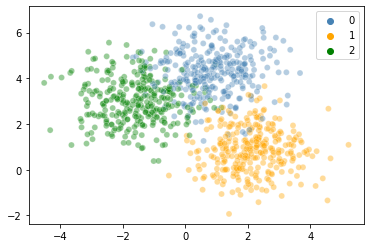

In [48]:
#Aqui, estou criando um conjunto de dados com 2 classes 0 e 1
#E consequentemente com duas gaussianas, uma para cada classe
#Defini que os dados só terão duas colunas
X, y = make_blobs(n_samples=900, n_features=2, centers=3, random_state=0)

fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, 
                alpha=0.4, ax=ax, palette=colors)
plt.show()
plt.close()

In [49]:
# your code here

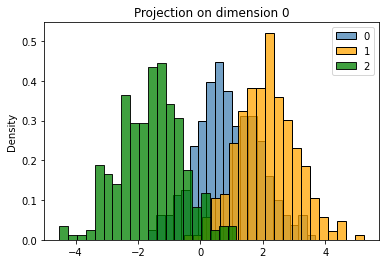

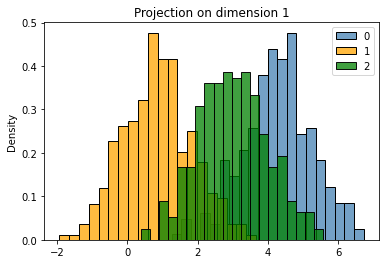

In [50]:
plot_projection(X[:, 0], y, '0')
plot_projection(X[:, 1], y,'1')

## Exercise 2 - Linear Discriminant Analysis

* Use sklearn's implementation of LDA to project the points in a single dimension

In [52]:
#Usando um modelo pronto do sklearn para fazer as projeções
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
proj = LinearDiscriminantAnalysis(n_components=1).fit_transform(X,y)
# plot_projection(proj.flatten(), y, 'w')

* use the default parameters for the LDA classifier, and report the prediction accuracy on a train/test split of 70/30 %
* report also the accuracy of the classifier you used in part 1 (you don't have to fit it to the single dimensional projection)

In [53]:
#Agora vamos comparar nosso modelo gaussiano com o modelo de Fisher
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lda = LinearDiscriminantAnalysis(store_covariance=True).fit(X_train, y_train)
g = SingleGaussianClassifier().fit(X_train, y_train)
print('Test Accuracies')
print(f'LDA classifier: {accuracy_score(lda.predict(X_test), y_test)}')
print(f'Single Gaussian fitting: {accuracy_score(g.predict(X_test), y_test)}')

Test Accuracies
LDA classifier: 0.937037037037037
Single Gaussian fitting: 0.937037037037037


## Exercise 3 - Try the same, on a "more difficult" dataset

* Load the "Part 2.tsv" file from Coursework 1 (provided in the zip file), 
* plot the data and histograms of the projections onto each dimension
* create a train/test split of 70/30 %
* compare the performance of the single gaussian model and LDA (test accuracy)

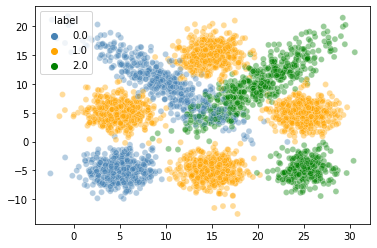

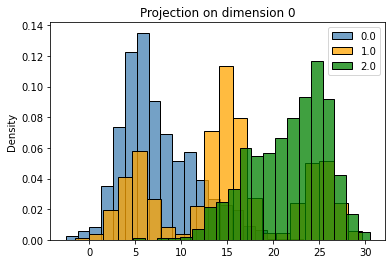

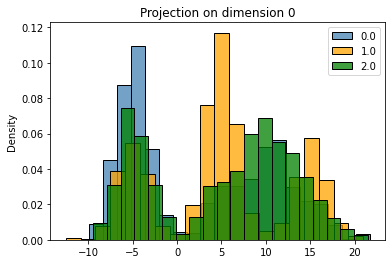

In [55]:
#Vamos tentar fazer essa projeção em um dataset gaussiano mais complexo
data = pd.read_csv('Part 2.tsv', sep='\t', index_col=0)
X = data[['x','y']].values
y = data['label']

fig, ax = plt.subplots()
sns.scatterplot(x=X[:,0], y=X[:, 1], hue=y, alpha=0.4, ax=ax, palette=colors)
plt.show()
plt.close('all')

plot_projection(X[:,0], y, '0')
plot_projection(X[:,1], y, '0')

In [59]:
#Mais uma vez testando a accurácia do modelo gaussiano e LDA do scikit learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lda = LinearDiscriminantAnalysis(store_covariance=True).fit(X_train, y_train)
g = SingleGaussianClassifier().fit(X_train, y_train)
print('Test Accuracies:')
print(f'LDA classifier: {accuracy_score(lda.predict(X_test), y_test)}')
print(f'Single Gaussian fitting: {accuracy_score(g.predict(X_test), y_test)}')

Test Accuracies:
LDA classifier: 0.5253333333333333
Single Gaussian fitting: 0.5137777777777778


# Part 3 - Perceptron

* Load the following classification datasets from scikit-learn
    * `digits`
    * `wine`
    * `breast_cancer`
    * `lfw_people`
* Use these datasets with a train test split of 70/30% and compare the accuracy scores of following perceptrons (scikit-learn implementation):
    * Default arguments
    * not shuffling the training
    * max_iter set to values from 1 to 10
    * max_iter set to values from 1 to 10, without shuffling the training

**TIP:** it's easier to visualize these results in table form, I suggest you collect them into a DataFrame    
**NOTE: you will get serveral warnings of non-convergence because of the very small maximum iteration parameters, but the idea is that you observe how this affects the learning, feel free to suppres the warnings**

In [60]:
from sklearn.linear_model import Perceptron
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [61]:
from sklearn.datasets import load_digits, load_wine, load_breast_cancer, fetch_lfw_people
#return_X_y faz a bib retornar somente X e y
load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

perceptrons = {
    ('default', 'YES'): Perceptron(),
    ('default', 'NO'): Perceptron(shuffle=False),
}
datasets = {
    'digits': load_digits(return_X_y=True),
    'wine': load_wine(return_X_y=True),
    'breast cancer': load_breast_cancer(return_X_y=True),
    #'LFW people': fetch_lfw_people(return_X_y=True)
}
#Atribuindo ao dicionário vários percptrons com com iterações de 1 a 11
# print({(f'max_iter = {i}', 'YES'): Perceptron(max_iter=i) for i in range(1, 11)})
perceptrons.update({(f'max_iter = {i}', 'YES'): Perceptron(max_iter=i) for i in range(1, 11)})
perceptrons.update({(f'max_iter = {i}', 'NO'): Perceptron(max_iter=i, shuffle=False) for i in range(1, 11)})
print(perceptrons)

data = {k:[] for k in ['name', 'accuracy', 'shuffle', 'dataset']}
print()
print(data)
for dataset, datapoints in datasets.items():
    
    X_train, X_test, y_train, y_test = train_test_split(datapoints[0], datapoints[1], test_size=0.3, random_state=0)
    
    for (name, shuffle), p in perceptrons.items():
        p.fit(X_train, y_train)
        acc = accuracy_score(p.predict(X_test), y_test)
        data['name'].append(name)
        data['accuracy'].append(acc)
        data['shuffle'].append(shuffle)
        data['dataset'].append(dataset)
df = pd.DataFrame(data)

{('default', 'YES'): Perceptron(), ('default', 'NO'): Perceptron(shuffle=False), ('max_iter = 1', 'YES'): Perceptron(max_iter=1), ('max_iter = 2', 'YES'): Perceptron(max_iter=2), ('max_iter = 3', 'YES'): Perceptron(max_iter=3), ('max_iter = 4', 'YES'): Perceptron(max_iter=4), ('max_iter = 5', 'YES'): Perceptron(max_iter=5), ('max_iter = 6', 'YES'): Perceptron(max_iter=6), ('max_iter = 7', 'YES'): Perceptron(max_iter=7), ('max_iter = 8', 'YES'): Perceptron(max_iter=8), ('max_iter = 9', 'YES'): Perceptron(max_iter=9), ('max_iter = 10', 'YES'): Perceptron(max_iter=10), ('max_iter = 1', 'NO'): Perceptron(max_iter=1, shuffle=False), ('max_iter = 2', 'NO'): Perceptron(max_iter=2, shuffle=False), ('max_iter = 3', 'NO'): Perceptron(max_iter=3, shuffle=False), ('max_iter = 4', 'NO'): Perceptron(max_iter=4, shuffle=False), ('max_iter = 5', 'NO'): Perceptron(max_iter=5, shuffle=False), ('max_iter = 6', 'NO'): Perceptron(max_iter=6, shuffle=False), ('max_iter = 7', 'NO'): Perceptron(max_iter=7, sh

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
digits = load_digits()
train_data, test_data, train_labels, test_labels = train_test_split(digits.data, digits.target,train_size=0.70)
for i in range(1,11):
    p_shuffle = Perceptron(random_state=0, max_iter=i, shuffle=True)
    p_shuffle.fit(train_data, train_labels)
    predictions_train= p_shuffle.predict(train_data)
    predictions_test = p_shuffle.predict(test_data)
    train_score = accuracy_score(predictions_test, test_labels)
    print(train_score)
    p = Perceptron(random_state=0, max_iter=i, shuffle=False)
    p.fit(train_data, train_labels)
    predictions_train= p.predict(train_data)
    predictions_test = p.predict(test_data)
    train_score = accuracy_score(predictions_test, test_labels)
    print(train_score)

    


0.8870370370370371
0.8740740740740741
0.8944444444444445
0.9111111111111111
0.9462962962962963
0.9333333333333333
0.8814814814814815
0.912962962962963
0.9462962962962963
0.9203703703703704
0.9296296296296296
0.9203703703703704
0.9333333333333333
0.9407407407407408
0.9314814814814815
0.9388888888888889
0.9203703703703704
0.9388888888888889
0.9518518518518518
0.937037037037037


In [65]:
from sklearn.metrics import accuracy_score
predictions_train = p.predict(train_data)
predictions_test = p.predict(test_data)
train_score = accuracy_score(predictions_train, train_labels)
print("score on train data: ", train_score)
test_score = accuracy_score(predictions_test, test_labels)
print("score on train data: ", test_score)


score on train data:  0.9745425616547335
score on train data:  0.937037037037037
